## Zarys problemu i opis zbioru danych

In [1]:
# Wczytanie pakietów
using Pkg
using QuartzImageIO
using Flux
using Flux: onehotbatch, onecold, crossentropy, throttle, @epochs
using Random
using StatsBase: mean
using Base.Iterators: partition
using DataFrames
using Printf, BSON, LinearAlgebra
using Plots
using StatsPlots
using DataFrames
using Images
using ImageMagick
using StatsBase

LoadError: ArgumentError: Package QuartzImageIO not found in current path:
- Run `import Pkg; Pkg.add("QuartzImageIO")` to install the QuartzImageIO package.


## Analiza eksploracyjna

In [15]:
# para - parasitized
# uninf - uninfected
mild = readdir("Alzheimer_s Dataset/train/MildDemented/")
mild = ["Alzheimer_s Dataset/train/MildDemented/"] .* mild[endswith.(mild, ".jpg")]

moderate = readdir("Alzheimer_s Dataset/train/ModerateDemented/")
moderate = ["Alzheimer_s Dataset/train/ModerateDemented/"] .* moderate[endswith.(moderate, ".jpg")]

non = readdir("Alzheimer_s Dataset/train/NonDemented/")
non = ["Alzheimer_s Dataset/train/NonDemented/"] .* non[endswith.(non, ".jpg")]

very = readdir("Alzheimer_s Dataset/train/VeryMildDemented/")
very = ["Alzheimer_s Dataset/train/VeryMildDemented/"] .* very[endswith.(very, ".jpg")]


["Mild:"; mild[1:5]; "Moderate"; moderate[1:5]; "Non"; non[1:5]; "Very"; very[1:5]]

24-element Array{String,1}:
 "Mild:"
 "Alzheimer_s Dataset/train/MildDemented/mildDem0.jpg"
 "Alzheimer_s Dataset/train/MildDemented/mildDem1.jpg"
 "Alzheimer_s Dataset/train/MildDemented/mildDem10.jpg"
 "Alzheimer_s Dataset/train/MildDemented/mildDem100.jpg"
 "Alzheimer_s Dataset/train/MildDemented/mildDem101.jpg"
 "Moderate"
 "Alzheimer_s Dataset/train/ModerateDemented/moderateDem0.jpg"
 "Alzheimer_s Dataset/train/ModerateDemented/moderateDem1.jpg"
 "Alzheimer_s Dataset/train/ModerateDemented/moderateDem10.jpg"
 "Alzheimer_s Dataset/train/ModerateDemented/moderateDem11.jpg"
 "Alzheimer_s Dataset/train/ModerateDemented/moderateDem12.jpg"
 "Non"
 "Alzheimer_s Dataset/train/NonDemented/nonDem0.jpg"
 "Alzheimer_s Dataset/train/NonDemented/nonDem1.jpg"
 "Alzheimer_s Dataset/train/NonDemented/nonDem10.jpg"
 "Alzheimer_s Dataset/train/NonDemented/nonDem100.jpg"
 "Alzheimer_s Dataset/train/NonDemented/nonDem1000.jpg"
 "Very"
 "Alzheimer_s Dataset/train/VeryMildDemented/verymildDem0.jpg"
 "Al

In [9]:
using DataFrames

data = DataFrame(id = para, para = 1)
data = [data; DataFrame(id = uninf, para = 0)]
first(data, 5)

LoadError: ArgumentError: Package DataFrames not found in current path:
- Run `import Pkg; Pkg.add("DataFrames")` to install the DataFrames package.


In [665]:
last(data, 5)

,id,para
,String,Int64
1,cell_images/Uninfected/C99P60ThinF_IMG_20150918_142128_cell_47.png,0
2,cell_images/Uninfected/C99P60ThinF_IMG_20150918_142128_cell_52.png,0
3,cell_images/Uninfected/C99P60ThinF_IMG_20150918_142128_cell_53.png,0
4,cell_images/Uninfected/C99P60ThinF_IMG_20150918_142128_cell_55.png,0
5,cell_images/Uninfected/C99P60ThinF_IMG_20150918_142128_cell_56.png,0


In [666]:
println("Liczba obrazków: ", size(data)[1])
println("Liczba obrazków z komórkami zainfekowanymi: ", sum(data[:, 2]))
println("Liczba obrazków z komórkami zdrowymi: ", sum(data[:, 2] .== 0))

Liczba obrazków: 27558
Liczba obrazków z komórkami zainfekowanymi: 13779
Liczba obrazków z komórkami zdrowymi: 13779


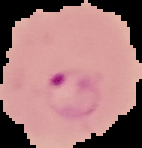

In [667]:
# Przykładowy obrazek zainfekowanej komórki
load(data[1, 1])

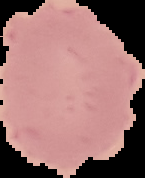

In [668]:
# Przykładowy obrazek zdrowej komórki
load(data[end, 1])

## Załadowanie obrazków
>Zmiana obrazków na odpowiedni do analizy rozmiar wynoszący 28x28 oraz zmiana kolorowego obrazka na obrazek w szarej skali.

# SAMPLE !!!!!!!!!!!!!!!!!!!!!!!!!!

In [698]:
###########
# SAMPLE #
# wybiera 1000 losowych obrazków zamiast całego zbioru
data = data[sample(1:nrow(data), 10000), :]
first(data, 10)

,id,para
,String,Int64
1,cell_images/Parasitized/C66P27N_ThinF_IMG_20150818_163419_cell_204.png,1
2,cell_images/Parasitized/C97P58ThinF_IMG_20150917_151320_cell_156.png,1
3,cell_images/Uninfected/C81P42ThinF_IMG_20150817_120856_cell_10.png,0
4,cell_images/Parasitized/C113P74ThinF_IMG_20150930_135904_cell_188.png,1
5,cell_images/Uninfected/C13NThinF_IMG_20150614_131617_cell_212.png,0
6,cell_images/Parasitized/C157P118ThinF_IMG_20151115_164755_cell_190.png,1
7,cell_images/Parasitized/C113P74ThinF_IMG_20150930_135904_cell_188.png,1
8,cell_images/Uninfected/C173P134NThinF_IMG_20151130_125408_cell_185.png,0
9,cell_images/Uninfected/C67P28N_ThinF_IMG_20150819_133000_cell_61.png,0


In [699]:
labels = data.para;

In [700]:
# Załadowanie obrazków, redukcja skali kolorów do odcieni szarości oraz rozmiaru obrazka do 28x28
images = []
for name in data.id
    push!(images, Gray.(imresize(load(name), 28, 28)))
end

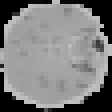

In [701]:
images[15]

In [702]:
labels[15]

1

# Podział na zbiór treningowy i testowy

In [703]:
share_sample = sample(1:size(images, 1), size(images, 1)) ./ size(images, 1) .<= 0.7;

images_train = images[share_sample]
labels_train = labels[share_sample]
images_test = images[.!share_sample]
labels_test = labels[.!share_sample];

In [704]:
epochs = 50;
batch_size = 64;

In [705]:
function make_minibatch(X, Y, idxs)
    X_batch = Array{Float32}(undef, size(X[1])..., 1, length(idxs))
    for i in 1:length(idxs)
        X_batch[:, :, :, i] = Float32.(X[idxs[i]])
    end
    Y_batch = onehotbatch(Y[idxs], 0:1)
    return (X_batch, Y_batch)
end

make_minibatch (generic function with 1 method)

In [706]:
mb_idxs = partition(1:length(images_train), batch_size)

train_set = [make_minibatch(images_train, labels_train, i) for i in mb_idxs]

# Prepare test set as one giant minibatch:
test_set = make_minibatch(images_test, labels_test, 1:length(images_test));

## test

1

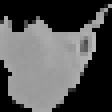

In [707]:
dd = 126
print(labels_train[dd])
images_train[dd]

# Model 1

In [708]:
model =   Chain(x -> reshape(x, :, size(x, 4)),
    Dense(784,256),
    Dropout(0.1), 
    Dense(256,256),
    Dropout(0.1),
    Dense(256,2),
    softmax,
);

In [709]:
# # Sieć głęboka mlp jako benchmark
# model =   Chain(x -> reshape(x, :, size(x, 4)),
#         Dense(784,256, relu), 
#         Dropout(0.5), 
#         Dense(256,128, relu),
#         Dropout(0.5),
#         Dense(128,64, relu),
#         Dropout(0.5),
#         Dense(64,2, relu),
#         softmax,
# );

In [710]:
# dla 64 x 64

# # Sieć głęboka mlp jako benchmark
# model =   Chain(x -> reshape(x, :, size(x, 4)),
#         Dense(64^2,256, relu), 
#         Dropout(0.5), 
#         Dense(256,128, relu),
#         Dropout(0.5),
#         Dense(128,64, relu),
#         Dropout(0.5),
#         Dense(64,2, relu),
#         softmax,
# );

In [711]:
model(train_set[1][1])

2×64 Array{Float32,2}:
 0.453102  0.361857  0.482646  0.405024  …  0.559623  0.405911  0.224365
 0.546898  0.638143  0.517354  0.594976     0.440377  0.594089  0.775635

In [712]:
train_set[1][2]

2×64 Flux.OneHotMatrix{Array{Flux.OneHotVector,1}}:
 false  false  false   true   true  …  false  false  false   true  false
  true   true   true  false  false      true   true   true  false   true

In [713]:
function loss(x, y)
    x_aug = x .+ 0.1f0*randn(eltype(x), size(x))
    y_hat = model(x_aug)
    return crossentropy(y_hat, y)
end

loss (generic function with 1 method)

In [714]:
train_set[1][2]

2×64 Flux.OneHotMatrix{Array{Flux.OneHotVector,1}}:
 false  false  false   true   true  …  false  false  false   true  false
  true   true   true  false  false      true   true   true  false   true

In [715]:
loss(train_set[1][1],train_set[1][2])

0.7138154f0

In [716]:
accuracy(x, y) = mean(onecold(model(x)) .== onecold(y))

accuracy (generic function with 1 method)

In [717]:
@time accuracy(test_set[1],test_set[2])

  0.055718 seconds (30.45 k allocations: 12.463 MiB, 31.27% gc time)


0.502539790044023

In [718]:
opt = ADAM(0.001)

ADAM(0.001, (0.9, 0.999), IdDict{Any,Any}())

In [719]:
@info("Beginning training loop...")
best_acc = 0.0
last_improvement = 0
for epoch = 1:epochs
    global best_acc, last_improvement
    Flux.train!(loss, params(model), train_set, opt)
    acc = accuracy(test_set[1],test_set[2])
    @info(@sprintf("[%d]: Test accuracy: %.4f", epoch, acc))
    if acc >= 0.90
        @info(" -> Early-exiting: We reached our target accuracy of 90%")
        break
    end
    if acc >= best_acc
        @info(" -> New best accuracy! Saving model out to fashionMNIST_conv.bson")
        BSON.@save "fashionMNIST_conv.bson" model epoch acc
        best_acc = acc
        last_improvement = epoch
    end
    if epoch - last_improvement >= 5 && opt.eta > 1e-6
        opt.eta /= 10.0
        @warn(" -> Haven't improved in a while, dropping learning rate to $(opt.eta)!")
        last_improvement = epoch
    end
    if epoch - last_improvement >= 10
        @warn(" -> We're calling this converged.")
        break
    end
end

┌ Info: Beginning training loop...
└ @ Main In[719]:1
┌ Info: [1]: Test accuracy: 0.5574
└ @ Main In[719]:8
┌ Info:  -> New best accuracy! Saving model out to fashionMNIST_conv.bson
└ @ Main In[719]:14
┌ Info: [2]: Test accuracy: 0.6746
└ @ Main In[719]:8
┌ Info:  -> New best accuracy! Saving model out to fashionMNIST_conv.bson
└ @ Main In[719]:14
┌ Info: [3]: Test accuracy: 0.6278
└ @ Main In[719]:8
┌ Info: [4]: Test accuracy: 0.7972
└ @ Main In[719]:8
┌ Info:  -> New best accuracy! Saving model out to fashionMNIST_conv.bson
└ @ Main In[719]:14
┌ Info: [5]: Test accuracy: 0.8049
└ @ Main In[719]:8
┌ Info:  -> New best accuracy! Saving model out to fashionMNIST_conv.bson
└ @ Main In[719]:14
┌ Info: [6]: Test accuracy: 0.6742
└ @ Main In[719]:8
┌ Info: [7]: Test accuracy: 0.8364
└ @ Main In[719]:8
┌ Info:  -> New best accuracy! Saving model out to fashionMNIST_conv.bson
└ @ Main In[719]:14
┌ Info: [8]: Test accuracy: 0.7802
└ @ Main In[719]:8
┌ Info: [9]: Test accuracy: 0.7958
└ @ Main 

In [720]:
# Precyzja na zbiorze testowym
@show(accuracy(test_set[1], test_set[2]))

accuracy(test_set[1], test_set[2]) = 0.8963765662038605


0.8963765662038605

><b>Wyniki:</b><br>Można zauważyć, że już na wstępie uczenia nie zaobserwowano znacznej poprawy właściwości prognostycznych modelu na zbiorze walidacyjnym. Pomimo dużej liczby iteracji algorytm <b>osiągnął niespełna 75% poziom precyzji na zbiorze testowym, co nie okazało się być wynikiem satysfakcjonującym.</b>

#### Model 2: Sieć konwolucyjna o prostszej architekturze

>W modelu drugim zdecydowano się zastosować elementy architektury o charakterze typowym dla sieci konwolucyjnym - tj. warstwę konwolucyjną. Dodatkowo zdecydowano się dodać padding, czyli 'powiększenie obrazka' o zero na krawędziach w celu zdobycia informacji również na końcach obrazka. W rezultacie model 2 składa się w jedej warstwy konwolucyjnej, paddingu, funkcji aktywacji w postaci funkcji ReLu oraz warstwy poolingu stosującej maksymalną wartość z obszaru 2x2. 
<br><br>  <b>Za benchmark przyjęto poziom accuracy 99%</b> na zbiorze walidacyjnym. W procesie uczenia przyjęto następujący algorytm postępowania: maksymalną liczbę iteracji ustalono na poziomie 15 z uwagi na ograniczenia systemowe i obliczeniowe posiadanego sprzętu. Jeśli model wcześnie osiągnie ustalone wcześniej kryterium to (tj. 99% accuracy) to przestaje trenować sieć. W przypadku poprawy wyniki są zapisywane a sieć dalej uczona.  

# dwa

In [721]:
#Architektura modelu 2
m2 = Chain(
    Conv((3, 3), 1=>32, pad=(1,1)),
    x -> maxpool(x, (2,2)),
    x -> reshape(x, :, size(x, 4)),
    Dense(6272, 2), 
    softmax);

In [722]:
# Model 2 - definicja hiperparametrów
loss(x, y) = crossentropy(m2(x), y) 
accuracy(x, y) = mean(onecold(m2(x),0:1) .== onecold(y,0:1))
evalcb = throttle(() -> @show(accuracy(test_set[1], test_set[2]),loss(test_set[1],test_set[2])), 64)
opt = ADAMW(0.001);

In [723]:
# Model 2 Proces uczenia
best_acc = 0.0
df = DataFrame(Epoch=1:epochs, Accuracy_test=0.0);
cntr = 1;
for i=1:epochs
    global best_acc, last_improvement
    Flux.train!(loss, params(m2), train_set, opt)
    df[cntr, :Epoch]=i
    df[cntr, :Accuracy_test]=accuracy(test_set[1], test_set[2])
    cntr+=1
    acc1 = accuracy(test_set[1], test_set[2])
        @info(@sprintf("[%d]: Precyzja na testowym: %.4f", i, acc1))
    if acc1 >= 0.99
        @info(" -> Wczesne zatrzymanie: Osiągnięto 99% precyzję")
        break
    end
    if acc1 >= best_acc
        @info(" -> Nowa najlepsza precyzja! Model zapisany do my_model.bson")
        BSON.@save "my_model.bson" m2 i acc1
        best_acc = acc1
        last_improvement = i
    end
end

┌ Info: [1]: Precyzja na testowym: 0.5008
└ @ Main In[723]:12
┌ Info:  -> Nowa najlepsza precyzja! Model zapisany do my_model.bson
└ @ Main In[723]:18
┌ Info: [2]: Precyzja na testowym: 0.5008
└ @ Main In[723]:12
┌ Info:  -> Nowa najlepsza precyzja! Model zapisany do my_model.bson
└ @ Main In[723]:18
┌ Info: [3]: Precyzja na testowym: 0.5008
└ @ Main In[723]:12
┌ Info:  -> Nowa najlepsza precyzja! Model zapisany do my_model.bson
└ @ Main In[723]:18
┌ Info: [4]: Precyzja na testowym: 0.5008
└ @ Main In[723]:12
┌ Info:  -> Nowa najlepsza precyzja! Model zapisany do my_model.bson
└ @ Main In[723]:18
┌ Info: [5]: Precyzja na testowym: 0.5008
└ @ Main In[723]:12
┌ Info:  -> Nowa najlepsza precyzja! Model zapisany do my_model.bson
└ @ Main In[723]:18
┌ Info: [6]: Precyzja na testowym: 0.5008
└ @ Main In[723]:12
┌ Info:  -> Nowa najlepsza precyzja! Model zapisany do my_model.bson
└ @ Main In[723]:18
┌ Info: [7]: Precyzja na testowym: 0.5008
└ @ Main In[723]:12
┌ Info:  -> Nowa najlepsza precy

In [724]:
df

,Epoch,Accuracy_test
,Int64,Float64
1,1,0.500847
2,2,0.500847
3,3,0.500847
4,4,0.500847
5,5,0.500847
6,6,0.500847
7,7,0.500847
8,8,0.500847
9,9,0.500847


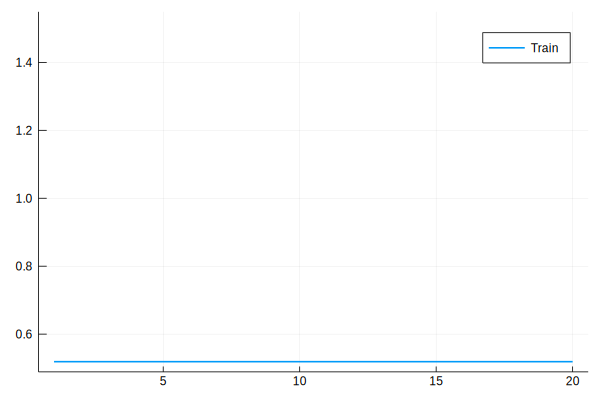

In [505]:
# Generowanie wykresu 
p_epoch = df[:,:Epoch]
p_test = df[:,:Accuracy_test]
p1 = plot(p_epoch,p_test,label=["Train"],lw=2)

In [508]:
@show(accuracy(test_set[1], test_set[2]))

accuracy(test_set[1], test_set[2]) = 0.5189003436426117


0.5189003436426117

><b>Wyniki:</b><br>Przy 15 iteracjach nie została osiągnięta ustalona trafność na zbiorze walidacyjnym (0,99), różnica wyniosła nieco ponad 0,05. Accuracy na zbiorze testowym wyniosło 0,939, natomiast na zbiorze walidacyjnym 0,937. Z wykresu wynika, iż do 10 epoki różnica w wartościach accuracy na obu zbiorach wynosiła do 0,005. Jak wskazuje wykres, w kolejnych epokach różnica ta ulegała zmiejszeniu i wyniosła w 15 epoce 0,002. Nie daje to podstawy, aby stwierdzić, iż model jest przeuczony.

#### Model 3: Sieć konwolucyjna o bardziej złożonej architekturze

>Model finałowy składa się z trzech warstw konwolucyjnych o rozmiarze 3x3, efektu padding (uzupełnianie zerami) wystepującym w każdej warstwie ukrytej oraz jako funkcję aktywacji przyjęto funkcję ReLu. Częstym błędem jest stosowanie zbyt dużych jąder splotowych, gdyż często ten sam efekt możemy uzyskać poprzez zmniejszenie jądra przy wprowadzeniu dodatkowej warstwy, ograniczając tym samym liczbę obliczeń i parametrów. Z tego powodu <b>rozmiar jądra ustalono więc na poziomie 3x3.</b> W warstwie pooling zdecydowano się zastosować taką funkcję która wybiera maksymalną wartość na obszarze 2x2. Liczba kanałów zmienia się z warstwy na warstwę. 
<br><br> W modelu 3 ustalono taki sam benchmark trafności wynoszący 0.99 na zbiorze walidacyjnym. Zastosowano również taki sam algorytm uczenia jak w modelu 2.


In [733]:
#Model 3
m3 = Chain(
    Conv((3, 3), 1=>16, pad=(1,1)),
    Conv((3, 3), 16=>32, pad=(1,1)),
    Conv((3, 3), 32=>32, pad=(1,1)),
    x -> reshape(x, :, size(x, 4)),
    Dense(288, 2), 
    softmax);

In [737]:
#Model 3
model = Chain(
    Conv((3, 3), 1=>16, pad=(1,1), relu),
    x -> maxpool(x, (2,2)),
    Conv((3, 3), 16=>32, pad=(1,1), relu),
    x -> maxpool(x, (2,2)),
    Conv((3, 3), 32=>32, pad=(1,1), relu),
    x -> maxpool(x, (2,2)),
    Dense(288, 2), 
    softmax);

In [738]:
loss(x, y) = crossentropy(m3(x), y) 
accuracy(x, y) = mean(onecold(m3(x),0:1) .== onecold(y,0:1))
evalcb = throttle(() -> @show(accuracy(test_set[1], test_set[2]),loss(test_set[1],test_set[2])), 64)
opt = ADAMW(0.001)

Flux.Optimise.Optimiser(Any[ADAM(0.001, (0.9, 0.999), IdDict{Any,Any}()), WeightDecay(0)])

###############

In [739]:
epochs = 20;

In [740]:
# Model 3: Proces uczenia
best_acc = 0.0
df = DataFrame(Epoch=1:epochs, Accuracy_test=0.0);
cntr = 1;
for i=1:epochs
    global best_acc, last_improvement
    Flux.train!(loss, params(m3), train_set, opt, cb = evalcb)
    df[cntr, :Epoch]=i
    df[cntr, :Accuracy_test]=accuracy(test_set[1],test_set[2])
    cntr+=1
    acc = accuracy(test_set[1],test_set[2])
        @info(@sprintf("[%d]: Precyzja na walidacyjnym: %.4f", i, acc))
    if acc >= 0.99
        @info(" -> Wczesne zatrzymanie: Osiągnięto 99% precyzję")
        break
    end
    if acc >= best_acc
        @info(" -> Nowa najlepsza precyzja! Model zapisany do my_model_3.bson")
        BSON.@save "my_model_3.bson" m3 i acc
        best_acc = acc
        last_improvement = i
    end
end

MethodError: MethodError: no method matching *(::Array{Float32,2}, ::Array{Float32,4})
Closest candidates are:
  *(::Any, ::Any, !Matched::Any, !Matched::Any...) at operators.jl:502
  *(::Union{DenseArray{T<:Union{Complex{Float32}, Complex{Float64}, Float32, Float64},2}, ReinterpretArray{T<:Union{Complex{Float32}, Complex{Float64}, Float32, Float64},2,S,A} where S where A<:Union{SubArray{T,N,A,I,true} where I<:Union{Tuple{Vararg{Real,N} where N}, Tuple{AbstractUnitRange,Vararg{Any,N} where N}} where A<:DenseArray where N where T, DenseArray}, ReshapedArray{T<:Union{Complex{Float32}, Complex{Float64}, Float32, Float64},2,A,MI} where MI<:Tuple{Vararg{SignedMultiplicativeInverse{Int64},N} where N} where A<:Union{ReinterpretArray{T,N,S,A} where S where A<:Union{SubArray{T,N,A,I,true} where I<:Union{Tuple{Vararg{Real,N} where N}, Tuple{AbstractUnitRange,Vararg{Any,N} where N}} where A<:DenseArray where N where T, DenseArray} where N where T, SubArray{T,N,A,I,true} where I<:Union{Tuple{Vararg{Real,N} where N}, Tuple{AbstractUnitRange,Vararg{Any,N} where N}} where A<:DenseArray where N where T, DenseArray}, SubArray{T<:Union{Complex{Float32}, Complex{Float64}, Float32, Float64},2,A,I,L} where L where I<:Tuple{Vararg{Union{Int64, AbstractRange{Int64}, AbstractCartesianIndex},N} where N} where A<:Union{ReinterpretArray{T,N,S,A} where S where A<:Union{SubArray{T,N,A,I,true} where I<:Union{Tuple{Vararg{Real,N} where N}, Tuple{AbstractUnitRange,Vararg{Any,N} where N}} where A<:DenseArray where N where T, DenseArray} where N where T, ReshapedArray{T,N,A,MI} where MI<:Tuple{Vararg{SignedMultiplicativeInverse{Int64},N} where N} where A<:Union{ReinterpretArray{T,N,S,A} where S where A<:Union{SubArray{T,N,A,I,true} where I<:Union{Tuple{Vararg{Real,N} where N}, Tuple{AbstractUnitRange,Vararg{Any,N} where N}} where A<:DenseArray where N where T, DenseArray} where N where T, SubArray{T,N,A,I,true} where I<:Union{Tuple{Vararg{Real,N} where N}, Tuple{AbstractUnitRange,Vararg{Any,N} where N}} where A<:DenseArray where N where T, DenseArray} where N where T, DenseArray}}, !Matched::Union{DenseArray{S,1}, ReinterpretArray{S,1,S,A} where S where A<:Union{SubArray{T,N,A,I,true} where I<:Union{Tuple{Vararg{Real,N} where N}, Tuple{AbstractUnitRange,Vararg{Any,N} where N}} where A<:DenseArray where N where T, DenseArray}, ReshapedArray{S,1,A,MI} where MI<:Tuple{Vararg{SignedMultiplicativeInverse{Int64},N} where N} where A<:Union{ReinterpretArray{T,N,S,A} where S where A<:Union{SubArray{T,N,A,I,true} where I<:Union{Tuple{Vararg{Real,N} where N}, Tuple{AbstractUnitRange,Vararg{Any,N} where N}} where A<:DenseArray where N where T, DenseArray} where N where T, SubArray{T,N,A,I,true} where I<:Union{Tuple{Vararg{Real,N} where N}, Tuple{AbstractUnitRange,Vararg{Any,N} where N}} where A<:DenseArray where N where T, DenseArray}, SubArray{S,1,A,I,L} where L where I<:Tuple{Vararg{Union{Int64, AbstractRange{Int64}, AbstractCartesianIndex},N} where N} where A<:Union{ReinterpretArray{T,N,S,A} where S where A<:Union{SubArray{T,N,A,I,true} where I<:Union{Tuple{Vararg{Real,N} where N}, Tuple{AbstractUnitRange,Vararg{Any,N} where N}} where A<:DenseArray where N where T, DenseArray} where N where T, ReshapedArray{T,N,A,MI} where MI<:Tuple{Vararg{SignedMultiplicativeInverse{Int64},N} where N} where A<:Union{ReinterpretArray{T,N,S,A} where S where A<:Union{SubArray{T,N,A,I,true} where I<:Union{Tuple{Vararg{Real,N} where N}, Tuple{AbstractUnitRange,Vararg{Any,N} where N}} where A<:DenseArray where N where T, DenseArray} where N where T, SubArray{T,N,A,I,true} where I<:Union{Tuple{Vararg{Real,N} where N}, Tuple{AbstractUnitRange,Vararg{Any,N} where N}} where A<:DenseArray where N where T, DenseArray} where N where T, DenseArray}}) where {T<:Union{Complex{Float32}, Complex{Float64}, Float32, Float64}, S} at C:\cygwin\home\Administrator\buildbot\worker\package_win64\build\usr\share\julia\stdlib\v1.1\LinearAlgebra\src\matmul.jl:45
  *(::Union{DenseArray{T,2}, ReinterpretArray{T,2,S,A} where S where A<:Union{SubArray{T,N,A,I,true} where I<:Union{Tuple{Vararg{Real,N} where N}, Tuple{AbstractUnitRange,Vararg{Any,N} where N}} where A<:DenseArray where N where T, DenseArray}, ReshapedArray{T,2,A,MI} where MI<:Tuple{Vararg{SignedMultiplicativeInverse{Int64},N} where N} where A<:Union{ReinterpretArray{T,N,S,A} where S where A<:Union{SubArray{T,N,A,I,true} where I<:Union{Tuple{Vararg{Real,N} where N}, Tuple{AbstractUnitRange,Vararg{Any,N} where N}} where A<:DenseArray where N where T, DenseArray} where N where T, SubArray{T,N,A,I,true} where I<:Union{Tuple{Vararg{Real,N} where N}, Tuple{AbstractUnitRange,Vararg{Any,N} where N}} where A<:DenseArray where N where T, DenseArray}, SubArray{T,2,A,I,L} where L where I<:Tuple{Vararg{Union{Int64, AbstractRange{Int64}, AbstractCartesianIndex},N} where N} where A<:Union{ReinterpretArray{T,N,S,A} where S where A<:Union{SubArray{T,N,A,I,true} where I<:Union{Tuple{Vararg{Real,N} where N}, Tuple{AbstractUnitRange,Vararg{Any,N} where N}} where A<:DenseArray where N where T, DenseArray} where N where T, ReshapedArray{T,N,A,MI} where MI<:Tuple{Vararg{SignedMultiplicativeInverse{Int64},N} where N} where A<:Union{ReinterpretArray{T,N,S,A} where S where A<:Union{SubArray{T,N,A,I,true} where I<:Union{Tuple{Vararg{Real,N} where N}, Tuple{AbstractUnitRange,Vararg{Any,N} where N}} where A<:DenseArray where N where T, DenseArray} where N where T, SubArray{T,N,A,I,true} where I<:Union{Tuple{Vararg{Real,N} where N}, Tuple{AbstractUnitRange,Vararg{Any,N} where N}} where A<:DenseArray where N where T, DenseArray} where N where T, DenseArray}} where T, !Matched::LinearAlgebra.AbstractQ) at C:\cygwin\home\Administrator\buildbot\worker\package_win64\build\usr\share\julia\stdlib\v1.1\LinearAlgebra\src\qr.jl:668
  ...

In [514]:
#Pokazanie tabeli z wynikami na zbiorze treningowym oraz walidacyjnym
df

,Epoch,Accuracy_test
,Int64,Float64
1,1,0.5189
2,2,0.5189
3,3,0.5189
4,4,0.5189
5,5,0.5189
6,6,0.5189
7,7,0.5189
8,8,0.5189
9,9,0.5189


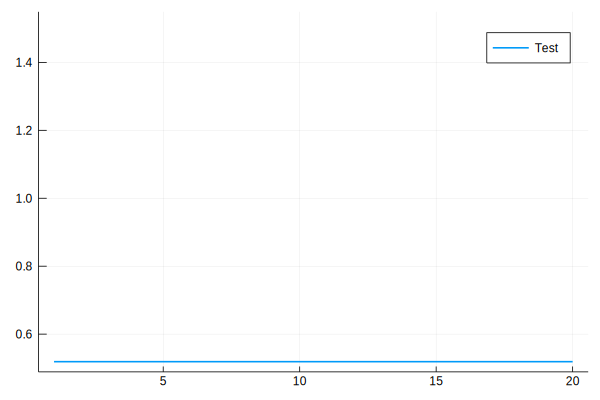

In [517]:
# Model 3: wykres 
p_epoch = df[:,:Epoch]
p_test = df[:,:Accuracy_test]
p1 = plot(p_epoch,p_test,label=["Test"],lw=2)

In [518]:
@show(accuracy(test_set[1],test_set[2]))

accuracy(test_set[1], test_set[2]) = 0.5189003436426117


0.5189003436426117

> <b>Wyniki:</b><br> Po 15 iteracjach nie udało się uzyskać maksymalnej, ustalonej trafności na zbiorze walidacyjnym chociaż różnica jest bardzo mała, gdyż wynosi jedynie 0.01. Z wykresu można wywnioskować, że model nie jest przeuczony gdyż wartości w epokach na zbiorze treningowym oraz walidacyjnym są podobne i największa ich róźnica wynosi 0.0053 w epoce 8 (co jest widoczne na obrazku - w tej epoce linie są położone najdalej od siebie). Accuracy na zbiorze testowym wyniosła około 0.97.  

## Porównanie trzech sieci
> Najlepsze wyniki pozwoliła uzyskać ostatnia sieć, która to cechuje się się najbardziej skomplikowaną architekturą - składa się z trzech warstw konwolucyjnych o rozmiarze 3x3, efektu padding wystepującym w każdej warstwie ukrytej oraz funkcji ReLu. Uzyskano dzięki niej przy 15 iteracjach wartość accuracy 0,98 na zbiorze walidacyjnym. Model drugi, składający się z jedej warstwy konwolucyjnej, paddingu, funkcji aktywacji w postaci funkcji ReLu oraz warstwy poolingu pozwolił na uzyskanie accuracy na zbiorze testowym o wartości 0,937, czyli o 0,043 mniej. Z kolei najgorsze rezultaty dał pierwszy model -  zwykła głęboka sieć neuronowa z czterema warstwami ukrytymi i funkcją aktywacji relu, a na warstwie wyjściowej funkcją softmax - uzyskał on accuracy 0,75.

## Podsumowanie
> Podsumowując, celem raportu było stworzenie modelu, która z jak największą precyzją pozwoli na rozpoznanie, czy na zdjęciu lotniczym znajduje się kaktus. W tym celu wykorzystano następujące dane: dokument tekstowy z identyfikatorami kaktusów i zmienną binarną, która przyjmuje wartość 1, gdy na zdjęciu znajduje się kaktus oraz wartość 0, gdy na zdjęciu nie znajduje się kaktus oraz 17500 miniaturowych obrazów w rozmiarze 32 x 32 zawierających lotnicze zdjęcia kaktusa. Aby zbudować jak najlepszy model przetrenowano wiele sieci, jednakże w pracy zaprezentowano jedynie trzy z oszacowanych modeli: model głębokiej sieci neuronowej z czterema warstwami ukrytymi i funkcją aktywacji relu, a na warstwie wyjściowej funkcją softmax oraz dwa modele sieci konwolucyjnej - pierwszy składał się z jednej warstwy konwolucyjnej, paddingu, funkcji aktywacji w postaci funkcji ReLu oraz warstwy poolingu, natomiast drugi miał bardziej skomplikowaną architekturę: składał się z trzech warstw konwolucyjnych o rozmiarze 3x3, efektu padding wystepującym w każdej warstwie ukrytej oraz funkcji ReLu. Model ostatni, czyli sieć konwolucyjna o bardziej skomplikowanej architekturze, okazał się być modelem najlepszym - pozwolił na uzyskanie wartości accuracy 0,98 na zbiorze testowym.  
Nie udało się uzyskać maksymalnej, ustalonej trafności 0,99 na zbiorze walidacyjnym, jednakże zachodzi możliwość, iż wartość ta zostałaby uzyskana, gdyby zwiększono liczbę iteracji, czego z uwagi na ograniczoną moc obliczeniową komputerów i ograniczenia systemowe nie można było sprawdzić.

## Bibliografia

<i>Deep Learning</i> - Ian Goodfellow, Aaron Courville
<br><i>Hands-On Machine Learning with Scikit-Learn and TensorFlow: Concepts, Tools, and Techniques to Build Intelligent Systems</i> - Aurelien Geron
<i>Revisiting Small Batch Training for Deep Neural Networks</i>, 2018 - Dominic Masters, Carlo Luschi.